In [1]:
import pandas as pd
from io import StringIO
import os
from datetime import datetime, timedelta
import time  # Added import for delay
from dataclasses import dataclass, field
from typing import List, Dict, Optional, Union, Set, Any
from enum import Enum
import pickle
import pandas as pd
import statsmodels.api as sm
import numpy as np
import logging
import unicodedata

from nst_scraper import nst_on_ice_scraper, nst_team_on_ice_scraper
from db_utils.nhl_db_utils import update_player_db, check_last_update, append_player_ids, get_player_full_name
from team_utils import get_most_recent_game_id, get_fullname_by_tricode
from game_utils import get_game_boxscore, display_boxscore
from pbp_utils import get_matchup_games
from db_utils.the_odds_db_utils import *

from dotenv import load_dotenv

pd.set_option('display.max_columns', None)
np.set_printoptions(legacy='1.21')

/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Uses the_odds_db_utils to get player shots on goal odds


In [2]:
# player_stats_df = nst_on_ice_scraper(fromseason=20242025, thruseason=20242025, startdate='', enddate='', rate='y')
# player_stats_df.head()

In [3]:
# goalie_stats_df = nst_on_ice_scraper(fromseason=20242025, thruseason=20242025, startdate='', enddate='', pos='g', rate='y', stdoi='g')
# goalie_stats_df.head()

In [4]:
class Position(Enum):
    C = 'C'
    L = 'L'
    R = 'R'
    D = 'D'
    G = 'G'
    
    @property
    def category(self) -> str:
        if self in {Position.C, Position.L, Position.R}:
            return 'F'
        elif self == Position.D:
            return 'D'
        elif self == Position.G:
            return 'G'
    
    def __str__(self) -> str:
        return self.value

In [5]:
@dataclass
class Player:
    name: str
    team: str
    position: Position
    player_id: Optional[int] = None

    def __str__(self) -> str:
        """
        Returns a string representation of the player.
        """
        return f"{self.name} ({self.position}) - {self.team}"

    def to_dict(self) -> Dict[str, Optional[str]]:
        """
        Converts the Player instance into a dictionary.
        
        Returns:
            Dict[str, Optional[str]]: A dictionary representation of the player.
        """
        return {
            'player_id': self.player_id,
            'name': self.name,
            'team': self.team,
            'position': self.position.value
        }

In [6]:
@dataclass
class Lineup:
    name: str
    forwards: List[Optional[Player]] = field(default_factory=lambda: [None] * 12)
    defense: List[Optional[Player]] = field(default_factory=lambda: [None] * 6)
    goalies: List[Optional[Player]] = field(default_factory=lambda: [None] * 2)
    
    ALLOWED_FORWARD_CATEGORIES = {'F'}
    ALLOWED_DEFENSE_CATEGORY = 'D'
    ALLOWED_GOALIE_CATEGORY = 'G'
    
    def __post_init__(self):
        self.validate_lineup_size()
    
    def validate_lineup_size(self):
        total_players = sum(player is not None for player in self.forwards + self.defense + self.goalies)
        if total_players > 20:
            raise ValueError(f"Total number of players ({total_players}) exceeds the hard limit of 20.")
    
    def add_player(
        self,
        category: str,
        player: Player,
        slot: int,
        allowed_categories: Union[str, Set[str]],
        max_slots: int
    ):
        """
        Adds a player to the specified category and slot after validating their position category.
        Ensures that the total number of players does not exceed 20.
        """
        if isinstance(allowed_categories, str):
            allowed_categories = {allowed_categories}
        elif isinstance(allowed_categories, set):
            allowed_categories = allowed_categories
        else:
            raise TypeError("allowed_categories must be a string or a set of strings.")
        
        if player.position.category not in allowed_categories:
            raise ValueError(
                f"Cannot add player '{player.name}' with position '{player.position.value}' "
                f"to {category}. Allowed categories: {', '.join(allowed_categories)}."
            )
        
        if not 0 <= slot < max_slots:
            raise IndexError(f"{category.capitalize()} slot must be between 0 and {max_slots - 1}.")
        
        current_category = getattr(self, category)
        if current_category[slot]:
            existing_player = current_category[slot].name
            print(f"Warning: Slot {slot + 1} in {category} is already occupied by '{existing_player}'. Overwriting.")
        
        # Check total players before adding
        total_players = sum(player is not None for player in self.forwards + self.defense + self.goalies)
        if current_category[slot] is None and total_players >= 20:
            raise ValueError("Cannot add more players. The lineup has reached the hard limit of 20 players.")
        
        current_category[slot] = player
        setattr(self, category, current_category)
        print(f"Added player '{player.name}' to {category.capitalize()} slot {slot + 1}.")
    
    def add_forward(self, player: Player, slot: int):
        self.add_player(
            category='forwards',
            player=player,
            slot=slot,
            allowed_categories=self.ALLOWED_FORWARD_CATEGORIES,
            max_slots=len(self.forwards)
        )
    
    def add_defense(self, player: Player, slot: int):
        self.add_player(
            category='defense',
            player=player,
            slot=slot,
            allowed_categories={self.ALLOWED_DEFENSE_CATEGORY},
            max_slots=len(self.defense)
        )
    
    def set_goalie(self, player: Player, slot: int):
        self.add_player(
            category='goalies',
            player=player,
            slot=slot,
            allowed_categories={self.ALLOWED_GOALIE_CATEGORY},
            max_slots=len(self.goalies)
        )
    
    def adjust_slots(self, category: str, delta: int):
        """
        Adjusts the number of slots in the specified category by delta.
        Allows ±1 adjustment only.
        
        Args:
            category (str): The category to adjust ('forwards' or 'defense').
            delta (int): The change in number of slots (+1 or -1).
        """
        if category not in {'forwards', 'defense'}:
            raise ValueError("Can only adjust 'forwards' or 'defense' categories.")
        if delta not in {-1, 1}:
            raise ValueError("Delta must be either +1 or -1.")
        
        current_slots = getattr(self, category)
        new_slot_count = len(current_slots) + delta
        
        if category == 'forwards':
            if not (11 <= new_slot_count <= 13):
                raise ValueError("Number of forwards can only vary by ±1 from the default of 12.")
        elif category == 'defense':
            if not (5 <= new_slot_count <= 7):
                raise ValueError("Number of defensemen can only vary by ±1 from the default of 6.")
        
        if delta == 1:
            current_slots.append(None)
        elif delta == -1:
            removed_player = current_slots.pop()
            if removed_player:
                print(f"Removed player '{removed_player.name}' from {category}.")
        
        setattr(self, category, current_slots)
        print(f"Adjusted {category} slots to {len(getattr(self, category))}.")
        self.validate_lineup_size()
    
    def display_lineup(self):
        """
        Prints the current lineup in a structured format.
        """
        print(f"Lineup: {self.name}\n")
        
        for category, title in [('forwards', 'Forwards'), ('defense', 'Defense'), ('goalies', 'Goalies')]:
            print(f"{title}:")
            for idx, player in enumerate(getattr(self, category), start=1):
                player_info = str(player) if player else 'Empty'
                print(f"  Slot {idx}: {player_info}")
            print()
    
    def to_dataframe(self) -> pd.DataFrame:
        """
        Converts the lineup into a pandas DataFrame.
        Conditionally includes player attributes if they are present.
        """
        data = []
        for category, pos in [('forwards', 'f'), ('defense', 'd'), ('goalies', 'g')]:
            for idx, player in enumerate(getattr(self, category), start=1):
                player_dict = {
                    'Position': f"{pos}{idx}",
                    'Player': player.name if player else 'Empty'
                }
                # Conditionally add 'player_id' if it exists
                if player and player.player_id is not None:
                    player_dict['Player ID'] = player.player_id
                data.append(player_dict)
        
        df = pd.DataFrame(data)
        
        # Optionally, remove columns where all values are NaN
        df.dropna(axis=1, how='all', inplace=True)
        
        return df
    
    def to_transposed_dataframe(self) -> pd.DataFrame:
        """
        Transposes the lineup DataFrame so that each column represents a position-slot combination
        and the row contains the corresponding player names.
        Conditionally includes additional player attributes if they are present.
        """
        df = self.to_dataframe()
        
        # Initialize dictionaries to hold player names and optional IDs
        player_data = {}
        id_data = {}
        
        for _, row in df.iterrows():
            pos = row['Position']
            player_name = row['Player']
            player_data[pos] = player_name
            
            # Handle 'Player ID' if it exists
            if 'Player ID' in row and pd.notna(row['Player ID']):
                id_data[f"{pos}_ID"] = row['Player ID']
        
        # Combine player names and IDs into a single dictionary
        transposed_data = {**player_data, **id_data}
        
        # Create the transposed DataFrame with a single row
        transposed_df = pd.DataFrame([transposed_data])
        
        return transposed_df

In [7]:
today_datetime= datetime.now()
yesterday_datetime = today_datetime - timedelta(days=1, hours=6) # UTC offset
yesterday = yesterday_datetime.strftime('%Y-%m-%d')
yesterday

'2025-01-03'

In [8]:
# Load environment variables from .env file
load_dotenv()

db_prefix = 'NHL_DB_'

# Check the last update time of the players database
last_update = check_last_update(db_prefix)

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Last database update was on: 2025-01-03
INFO:db_utils.base_utils:Database connection closed.


In [9]:
# Convert last_update to datetime
last_update_dt = datetime.strptime(last_update, '%Y-%m-%d')
today_dt = datetime.strptime(today_datetime.strftime('%Y-%m-%d'), '%Y-%m-%d')
yesterday_dt = datetime.strptime(yesterday, '%Y-%m-%d')

# Only update if last update was before yesterday
if last_update_dt not in [today_dt, yesterday_dt]:
    # Update the player database from last update to yesterday
    update_player_db(last_update, yesterday, db_prefix, skip_existing=True)
else:
    print(f"No need to update the player database. Last update was on: {last_update}")


No need to update the player database. Last update was on: 2025-01-03


In [10]:
def add_player_to_lineup(lineup: Lineup, player: Player, category: str):
    """
    Adds a player to the lineup in the specified category, handling potential errors.
    
    Args:
        lineup (Lineup): The lineup object.
        player (Player): The player to add.
        category (str): The category ('forwards', 'defense', 'goalies').
    """
    try:
        if category == 'forwards':
            slot = next(i for i, p in enumerate(lineup.forwards) if p is None)
            lineup.add_forward(player, slot)
        elif category == 'defense':
            slot = next(i for i, p in enumerate(lineup.defense) if p is None)
            lineup.add_defense(player, slot)
        elif category == 'goalies':
            slot = next(i for i, p in enumerate(lineup.goalies) if p is None)
            lineup.set_goalie(player, slot)
        else:
            print(f"Unknown category '{category}'.")
    except StopIteration:
        print(f"No available slots to add player '{player.name}' in category '{category}'.")
    except ValueError as ve:
        print(ve)
    except IndexError as ie:
        print(ie)

In [11]:
def get_skater_stats(lineup: Lineup, player_stats_df: pd.DataFrame, filter: Optional[str] = None) -> pd.DataFrame:
    """
    Gets stats for players in the lineup, maintaining lineup order.
    
    Args:
        lineup (Lineup): The lineup containing players
        player_stats_df (pd.DataFrame): DataFrame with player statistics
        filter (str, optional): Type of filter to apply on the stats.
            Defaults to None, which keeps all stats. If 'shots', only shot-related statistics are kept.
        
    Returns:
        pd.DataFrame: Player statistics ordered according to lineup positions
    """
    # Apply filter if specified
    if filter == 'shots':
        # Define shot-related columns to keep
        shot_columns = ['player', 'team', 'position', 'gp', 'toi', 'toi/gp','shots/60', 'icf/60', 'iff/60'] 
        player_stats_df = player_stats_df[shot_columns]
    
    # Create ordered list of players (forwards then defense)
    players = []
    # Add forwards in order
    players.extend([p for p in lineup.forwards if p])
    # Add defense in order 
    players.extend([p for p in lineup.defense if p])
    
    # Create ordered list of player names
    player_names = [player.name for player in players]
    
    # Filter stats and reorder to match lineup order
    stats_df = player_stats_df[player_stats_df['player'].isin(player_names)]
    
    # Ensure all players are from the same team
    team_codes = stats_df['team'].unique()
    if len(team_codes) > 1:
        # Assuming lineup is for a single team, get the team from the first player in the lineup
        team_code = None
        for player in lineup.forwards + lineup.defense + lineup.goalies:
            if player:
                team_code = player.team
                break
        if team_code:
            stats_df = stats_df[stats_df['team'] == team_code]
        else:
            raise ValueError("No players found in lineup to determine team.")
    
    # Create ordering dictionary mapping names to their position in lineup
    name_to_position = {name: idx for idx, name in enumerate(player_names)}
    
    # Sort stats DataFrame based on lineup order and reset index
    return stats_df.assign(
        lineup_order=stats_df['player'].map(name_to_position)
    ).sort_values('lineup_order').drop('lineup_order', axis=1).reset_index(drop=True)

# lineup_player_stats = get_skater_stats(my_lineup, player_stats_df)

In [12]:
def get_goalie_stats(lineup: Lineup, goalie_stats_df: pd.DataFrame) -> pd.DataFrame:
    """
    Gets stats for goalies in the lineup, maintaining lineup order.
    
    Args:
        lineup (Lineup): The lineup containing goalies
        goalie_stats_df (pd.DataFrame): DataFrame with goalie statistics
        
    Returns:
        pd.DataFrame: Goalie statistics ordered according to lineup positions
    """
    # Create ordered list of goalies
    goalies = [goalie for goalie in lineup.goalies if goalie]
    goalie_names = [goalie.name for goalie in goalies]
    
    # Filter stats and reorder to match lineup order
    stats_df = goalie_stats_df[goalie_stats_df['player'].isin(goalie_names)]
    
    # Create ordering dictionary mapping names to their position in lineup
    name_to_position = {name: idx for idx, name in enumerate(goalie_names)}
    
    # Sort stats DataFrame based on lineup order and reset index
    return stats_df.assign(
        lineup_order=stats_df['player'].map(name_to_position)
    ).sort_values('lineup_order').drop('lineup_order', axis=1).reset_index(drop=True)

In [13]:
def extract_team_lineup(team: str, reference_date: Optional[str] = None) -> Lineup:
    """
    Extracts the most recent lineup for the specified team based on the latest game data.

    This function performs the following steps:
        1. Determines the reference date (defaults to yesterday if not provided).
        2. Retrieves the most recent game ID for the team using `get_most_recent_game_id`.
        3. Fetches the game boxscore data using `get_game_boxscore`.
        4. Processes the boxscore to obtain skaters and goalies using `display_boxscore`.
        5. Constructs and returns a `Lineup` object populated with the team's players.

    Args:
        team (str): The three-letter team code (e.g., 'TOR').
        reference_date (Optional[str]): The reference date in 'YYYY-MM-DD' format. Defaults to yesterday's date.

    Returns:
        Lineup: A `Lineup` object containing the team's players from the most recent game.

    Raises:
        ValueError: If no recent game is found for the team or if the team is not part of the retrieved game.
    """
    # Step 1: Determine the reference date
    if reference_date is None:
        today_datetime = datetime.now()
        yesterday_datetime = today_datetime - timedelta(days=1, hours=6)  # Adjust for UTC offset if necessary
        reference_date = yesterday_datetime.strftime('%Y-%m-%d')

    # Step 2: Retrieve the most recent game ID for the team
    game_id = get_most_recent_game_id(team, reference_date)
    if game_id is None:
        raise ValueError(f"No recent game found for team '{team}' before {reference_date}.")

    # Print the game_id
    print(f"Game ID: {game_id}")

    # Step 3: Fetch the game boxscore data
    game_data = get_game_boxscore(game_id, clean=False)

    # Step 4: Process the boxscore to obtain skaters and goalies
    away_skaters, away_goalies, home_skaters, home_goalies = display_boxscore(game_data)

    # Extract team abbrevs to determine if the team is home or away
    away_team_code = game_data.get('awayTeam', {}).get('abbrev')
    home_team_code = game_data.get('homeTeam', {}).get('abbrev')

    if not away_team_code or not home_team_code:
        raise ValueError("Team abbreviations not found in game data.")

    if team.upper() == away_team_code.upper():
        team_side = 'Away'
        skaters = away_skaters
        goalies = away_goalies
    elif team.upper() == home_team_code.upper():
        team_side = 'Home'
        skaters = home_skaters
        goalies = home_goalies
    else:
        raise ValueError(f"Team '{team}' not found in game ID {game_id}.")

    # Step 5: Construct the Lineup object
    lineup = Lineup(name=f"{team.upper()} Lineup from Game {game_id}")

    # Add Skaters to the Lineup
    for _, skater in skaters.iterrows():
        try:
            position_enum = Position(skater['position'])  # Convert to Position Enum
        except ValueError:
            print(f"Invalid position '{skater['position']}' for player '{skater['name']}'. Skipping.")
            continue

        player = Player(
            player_id=skater['playerId'],
            name=get_player_full_name(skater['playerId'], db_prefix, suppress_log=True),
            team=team.upper(),
            position=position_enum
        )

        # Add player to the appropriate category in the lineup
        if player.position.category == 'F':
            try:
                empty_slot = next(i for i, p in enumerate(lineup.forwards) if p is None)
                lineup.add_forward(player, empty_slot)
            except StopIteration:
                print(f"No available forward slot to add player '{player.name}'.")
        elif player.position.category == 'D':
            try:
                empty_slot = next(i for i, p in enumerate(lineup.defense) if p is None)
                lineup.add_defense(player, empty_slot)
            except StopIteration:
                print(f"No available defense slot to add player '{player.name}'.")
        else:
            print(f"Player '{player.name}' has an unrecognized category '{player.position.category}'. Skipping.")

    # Add Goalies to the Lineup
    for _, goalie in goalies.iterrows():
        player = Player(
            player_id=goalie['playerId'],
            name=get_player_full_name(goalie['playerId'], db_prefix, suppress_log=True),
            team=team.upper(),
            position=Position.G
        )
        try:
            empty_slot = next(i for i, p in enumerate(lineup.goalies) if p is None)
            lineup.set_goalie(player, empty_slot)
        except StopIteration:
            print(f"No available goalie slot to add player '{player.name}'.")

    return lineup
# chicago_lineup = extract_team_lineup('CHI', '2024-11-22')

In [14]:
def calculate_min_percentage(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the average time on ice per game as a percentage of total game time (60 minutes).
    
    Args:
        df (pd.DataFrame): DataFrame containing 'toi' and 'gp' columns
        
    Returns:
        pd.DataFrame: Original DataFrame with new 'min%' column added
    """
    df_copy = df.copy()
    df_copy['min%'] = (df_copy['toi'] / df_copy['gp'] / 300 * 100).round(2)
    return df_copy

# # Apply the function to lineup_player_stats
# lineup_player_stats = calculate_min_percentage(lineup_player_stats)
# lineup_player_stats

In [15]:
def sum_min_percentage(df: pd.DataFrame) -> float:
    """
    Calculates the sum of the 'min%' column in the given DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame containing the 'min%' column.
        
    Returns:
        float: The total sum of the 'min%' values.
        
    Raises:
        KeyError: If the 'min%' column is not present in the DataFrame.
    """
    if 'min%' not in df.columns:
        raise KeyError("The DataFrame does not contain a 'min%' column.")
    
    total_min_percentage = df['min%'].sum()
    return total_min_percentage

# Example usage:
# total_min_percentage = sum_min_percentage(lineup_player_stats)
# print(f"Total min%: {total_min_percentage}")

In [16]:
def calculate_adj_min(df: pd.DataFrame, total_min_percentage: float) -> None:
    """
    Calculates the adjusted minimum (adj_min) for each player based on their min% and the total min%.
    
    The formula used is:
        adj_min = (min% / total_min_percentage) * 300
    
    Args:
        df (pd.DataFrame): DataFrame containing the 'min%' column.
        total_min_percentage (float): The total sum of the 'min%' column.
        
    Raises:
        KeyError: If the 'min%' column is not present in the DataFrame.
        ValueError: If total_min_percentage is not a positive number.
    """
    if 'min%' not in df.columns:
        raise KeyError("The DataFrame does not contain a 'min%' column.")
    
    if total_min_percentage <= 0:
        raise ValueError("total_min_percentage must be a positive number.")
    
    # Calculate and append the 'adj_min' column
    df['adj_min'] = ((df['min%'] / total_min_percentage) * 300).round(2)

# # Example usage:
# calculate_adj_min(lineup_player_stats, total_min_percentage)
# print(lineup_player_stats[['player', 'min%', 'adj_min']])

In [17]:
# Define file paths to load the model and transformer
model_filepath = 'models/polynomial_model_degree_1.pkl'
poly_filepath = 'models/polynomial_features_degree_1.pkl'

# Load the regression model
with open(model_filepath, 'rb') as model_file:
    loaded_model = pickle.load(model_file)
print(f"Model loaded from {model_filepath}")

# Load the PolynomialFeatures transformer
with open(poly_filepath, 'rb') as poly_file:
    loaded_poly = pickle.load(poly_file)
print(f"PolynomialFeatures transformer loaded from {poly_filepath}")

# Function to make predictions using the loaded model and transformer
def predict_gpm(new_ixg60_value, model, poly, x_col='ixg60'):
    """
    Predicts 'gpm' using the loaded model and polynomial transformer.
    
    Parameters:
        new_ixg60_value (float): The new ixg60 value for prediction.
        model (RegressionResults): The loaded regression model.
        poly (PolynomialFeatures): The loaded polynomial features transformer.
        x_col (str): The name of the independent variable column. Defaults to 'ixg60'.
        
    Returns:
        predicted_gpm (float): The predicted gpm value.
    """
    # Prepare the input data
    X_new = np.array([[new_ixg60_value]])
    X_new_poly = poly.transform(X_new)
    X_new_poly_const = sm.add_constant(X_new_poly, has_constant='add')
    
    # Create DataFrame with appropriate column names
    feature_names = ['const'] + poly.get_feature_names_out([x_col]).tolist()
    new_data = pd.DataFrame(X_new_poly_const, columns=feature_names)
    
    # Predict
    predicted_gpm = model.predict(new_data)
    return predicted_gpm.iloc[0]

# Example: Predicting 'gpm' for a new ixg60 value
# new_ixg60_value = 50
# predicted_gpm = predict_gpm(new_ixg60_value, loaded_model, loaded_poly)
# print(f"Predicted GPM for ixg60={new_ixg60_value}: {predicted_gpm:.4f}")

Model loaded from models/polynomial_model_degree_1.pkl
PolynomialFeatures transformer loaded from models/polynomial_features_degree_1.pkl


In [18]:
# Function to predict GPM for each player and add it to the DataFrame
def add_gpm_to_lineup(lineup_df, model, poly):
    """
    Adds a 'gpm' column to the lineup_player_stats DataFrame using the predict_gpm function.
    
    Args:
        lineup_df (pd.DataFrame): DataFrame containing 'ixg/60' column.
        model: Loaded regression model.
        poly: Loaded PolynomialFeatures transformer.
        
    Returns:
        pd.DataFrame: Updated DataFrame with 'gpm' column added.
    """
    # Define a helper function to handle potential missing or invalid values
    def safe_predict(ixg_60):
        if pd.isna(ixg_60):
            return np.nan
        try:
            return predict_gpm(ixg_60, model, poly)
        except Exception as e:
            print(f"Error predicting GPM for ixg_60={ixg_60}: {e}")
            return np.nan
    
    # Apply the predict_gpm function to each 'ixg/60' value
    lineup_df['gpm'] = lineup_df['ixg/60'].apply(safe_predict)
    return lineup_df

# # Apply the function to add 'gpm' to your DataFrame
# lineup_player_stats = add_gpm_to_lineup(lineup_player_stats, loaded_model, loaded_poly)

# # Display the updated DataFrame with 'gpm'
# print(lineup_player_stats[['player', 'ixg/60', 'gpm']])

In [19]:
def calculate_x_goals(lineup_stats_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates 'x_goals' by multiplying 'gpm' with 'adj_min' for each player.
    
    Args:
        lineup_stats_df (pd.DataFrame): DataFrame containing 'gpm' and 'adj_min' columns.
        
    Returns:
        pd.DataFrame: DataFrame with the new 'x_goals' column added.
        
    Raises:
        KeyError: If 'gpm' or 'adj_min' columns are not present in the DataFrame.
        TypeError: If 'gpm' or 'adj_min' contain non-numeric data.
    """
    # Check if required columns exist
    required_columns = {'gpm', 'adj_min'}
    missing_columns = required_columns - set(lineup_stats_df.columns)
    if missing_columns:
        raise KeyError(f"The DataFrame is missing the following required columns: {', '.join(missing_columns)}")
    
    # Check if 'gpm' and 'adj_min' are numeric
    if not pd.api.types.is_numeric_dtype(lineup_stats_df['gpm']):
        raise TypeError("'gpm' column must be numeric.")
    if not pd.api.types.is_numeric_dtype(lineup_stats_df['adj_min']):
        raise TypeError("'adj_min' column must be numeric.")
    
    # Calculate 'x_goals'
    lineup_stats_df = lineup_stats_df.copy()
    lineup_stats_df['x_goals'] = lineup_stats_df['gpm'] * lineup_stats_df['adj_min']
    
    return lineup_stats_df

In [20]:
def calculate_league_avg_xg_against_per_60(goalie_stats_df: pd.DataFrame) -> float:
    """
    Calculate the league average expected goals against (xg_against) per 60 minutes.

    Args:
        goalie_stats_df (pd.DataFrame): DataFrame containing goalie statistics with 'xg_against' and 'toi' columns.

    Returns:
        float: The league average xg_against per 60 minutes.

    Raises:
        KeyError: If required columns are missing from the DataFrame.
        ValueError: If no valid goalies with non-zero 'toi' are found.
    """
    # Ensure required columns are present
    required_columns = {'xg_against', 'toi'}
    missing_columns = required_columns - set(goalie_stats_df.columns)
    if missing_columns:
        raise KeyError(f"Missing columns in goalie_stats_df: {', '.join(missing_columns)}")

    # Drop rows with missing or zero 'toi' to avoid division errors
    valid_goalies = goalie_stats_df.dropna(subset=['xg_against', 'toi'])
    valid_goalies = valid_goalies[valid_goalies['toi'] > 0]

    if valid_goalies.empty:
        raise ValueError("No valid goalies with non-zero 'toi' found in goalie_stats_df.")

    # Calculate xg against per 60 minutes for each goalie
    valid_goalies['xg_against_per_60'] = (valid_goalies['xg_against'] / valid_goalies['toi']) * 60

    # Calculate the league average
    league_avg_xg_against_per_60 = valid_goalies['xg_against_per_60'].mean()

    return league_avg_xg_against_per_60

In [21]:
def calculate_xg_against_adj_percentage(lineup_goalie_stats, goalie_avg_xg_against_per_60):
    """
    Calculate the expected goals against adjusted percentage.
    """
    lineup_goalie_stats['adj%'] = (lineup_goalie_stats['xg_against/60'] / goalie_avg_xg_against_per_60) * 100
    return lineup_goalie_stats

In [22]:
def load_models(model_filepath='models/polynomial_model_degree_1.pkl',
               poly_filepath='models/polynomial_features_degree_1.pkl'):
    """
    Loads the regression model and PolynomialFeatures transformer from the specified file paths.

    Args:
        model_filepath (str): Path to the saved regression model pickle file.
        poly_filepath (str): Path to the saved PolynomialFeatures transformer pickle file.

    Returns:
        tuple: A tuple containing the loaded regression model and PolynomialFeatures transformer.

    Raises:
        FileNotFoundError: If either of the specified files does not exist.
        pickle.UnpicklingError: If there is an error unpickling the files.
    """
    try:
        # Load the regression model
        with open(model_filepath, 'rb') as model_file:
            loaded_model = pickle.load(model_file)
        print(f"Model loaded from {model_filepath}")

        # Load the PolynomialFeatures transformer
        with open(poly_filepath, 'rb') as poly_file:
            loaded_poly = pickle.load(poly_file)
        print(f"PolynomialFeatures transformer loaded from {poly_filepath}")

        return loaded_model, loaded_poly

    except FileNotFoundError as fnf_error:
        print(f"Error: {fnf_error}")
        raise
    except pickle.UnpicklingError as pickle_error:
        print(f"Error loading pickle files: {pickle_error}")
        raise
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        raise

In [23]:
# Load the models using the new function
loaded_model, loaded_poly = load_models()

Model loaded from models/polynomial_model_degree_1.pkl
PolynomialFeatures transformer loaded from models/polynomial_features_degree_1.pkl


In [24]:
def calculate_x_shots(lineup_stats_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates 'x_shots' by multiplying 'shots/60' divided by 60 with 'adj_min' for each player.
    
    Args:
        lineup_stats_df (pd.DataFrame): DataFrame containing 'shots/60' and 'adj_min' columns.
        
    Returns:
        pd.DataFrame: DataFrame with the new 'x_goals' column added.
        
    Raises:
        KeyError: If 'shots/60' or 'adj_min' columns are not present in the DataFrame.
        TypeError: If 'shots/60' or 'adj_min' contain non-numeric data.
    """
    # Check if required columns exist
    required_columns = {'shots/60', 'adj_min'}
    missing_columns = required_columns - set(lineup_stats_df.columns)
    if missing_columns:
        raise KeyError(f"The DataFrame is missing the following required columns: {', '.join(missing_columns)}")
    
    # Check if 'shots/60' and 'adj_min' are numeric
    if not pd.api.types.is_numeric_dtype(lineup_stats_df['shots/60']):
        raise TypeError("'shots/60' column must be numeric.")
    if not pd.api.types.is_numeric_dtype(lineup_stats_df['adj_min']):
        raise TypeError("'adj_min' column must be numeric.")
    
    # Calculate 'x_shots' formatted to 2 decimal points
    lineup_stats_df = lineup_stats_df.copy()
    lineup_stats_df['x_shots'] = ((lineup_stats_df['shots/60'] / 60) * lineup_stats_df['adj_min']).round(2)
    
    return lineup_stats_df

In [25]:
def process_team_lineup_shots(input_date: str, team: str, player_stats_df: pd.DataFrame=None) -> pd.DataFrame:
    """
    Processes the team's lineup for a given date and predicts shots for each player.

    This function performs the following steps:
        1. Calls `nst_on_ice_scraper` for the input date minus one day to retrieve player and goalie statistics.
        2. Extracts the team's lineup using `extract_team_lineup`.
        3. Retrieves skater statistics with `get_skater_stats`, filtering by 'shots'.
        4. Calculates `min%` using `calculate_min_percentage`.
        5. Computes `adj_min` using `calculate_adj_min` based on total min%.
        6. Calculates `x_shots` by multiplying 'shots/60' by `adj_min`.

    Args:
        input_date (str): The reference date in 'YYYY-MM-DD' format.
        team (str): The three-letter team code (e.g., 'TOR').
        player_stats_df (pd.DataFrame, optional): DataFrame containing player statistics. Defaults to None.

    Returns:
        pd.DataFrame: Updated DataFrame with calculated metrics and predicted shots (`x_shots`).

    Raises:
        ValueError: If any step in the data processing pipeline fails.
    """

    try:
        # Step 1: Calculate the date minus one day
        reference_datetime = datetime.strptime(input_date, '%Y-%m-%d') - timedelta(days=1)
        reference_date_str = reference_datetime.strftime('%Y-%m-%d')
        print(f"Fetching data for reference date: {reference_date_str}")

        # Step 2: Call nst_on_ice_scraper for player and goalie stats
        if player_stats_df is None or player_stats_df.empty:
            player_stats_df = nst_on_ice_scraper(
                fromseason=20242025,
                thruseason=20242025,
                startdate='',
                enddate=reference_date_str,
                rate='y'
            )
            print("Player and goalie statistics fetched successfully.")
        else:
            print("Player and goalie statistics already provided.")

        # Step 3: Extract team lineup for the input date and team
        lineup = extract_team_lineup(team, input_date)
        print(f"Lineup extracted for team {team} on {input_date}.")

        # Step 4: Get skater statistics for the lineup
        lineup_skater_stats = get_skater_stats(lineup, player_stats_df, filter='shots')

        # Step 5: Calculate min%
        lineup_skater_stats = calculate_min_percentage(lineup_skater_stats)

        # Step 6: Calculate adj_min
        total_min_percentage = sum_min_percentage(lineup_skater_stats)
        calculate_adj_min(lineup_skater_stats, total_min_percentage)

        # Step 7: Calculate x_shots
        lineup_skater_stats = calculate_x_shots(lineup_skater_stats)
        
        return lineup_skater_stats

    except Exception as e:
        print(f"An error occurred during processing: {e}")
        raise

# shots = process_team_lineup_shots('2024-12-09', 'NYR')
# shots

In [26]:
def process_team_shots_and_opponent(input_date: str, team: str, player_stats_df: pd.DataFrame=None, team_stats_df: pd.DataFrame=None) -> Dict[str, Any]:
    """
    Processes a team's lineup shots and retrieves opponent's on-ice statistics for a given date.
    
    This function performs the following steps:
        1. Runs `process_team_lineup_shots` for the specified team and date.
        2. Retrieves the game_id where the team played on the specified date.
        3. Identifies the opponent team based on the game_id.
        4. Converts the opponent team's triCode to its full name.
        5. Uses `nst_team_on_ice_scraper` to fetch the opponent team's on-ice statistics.
    
    Args:
        input_date (str): The reference date in 'YYYY-MM-DD' format.
        team (str): The three-letter team code (e.g., 'TOR').
    
    Returns:
        Dict[str, Any]: A dictionary containing the team's lineup shots DataFrame, game_id, opponent team code,
                        and opponent's on-ice statistics DataFrame.
    
    Raises:
        ValueError: If the team did not play on the specified date or if the opponent cannot be determined.
    """
    try:
        # Step 1: Determine the reference date, if input_date is None, use yesterday's date
        if input_date is None:
            today_datetime = datetime.now()
            yesterday_datetime = today_datetime - timedelta(days=1, hours=6)  # Adjust for UTC offset if necessary
            input_date = yesterday_datetime.strftime('%Y-%m-%d')
        else:
            input_datetime = datetime.strptime(input_date, '%Y-%m-%d')
            day_before_input_dt = input_datetime - timedelta(days=1, hours=6)
            day_before_input = day_before_input_dt.strftime('%Y-%m-%d')

        # Step 2: Run process_team_lineup_shots for the given team and date
        team_shots_df = process_team_lineup_shots(input_date, team, player_stats_df)
        
        # Insert date as the first column
        team_shots_df.insert(0, 'date', input_date)
        
        print(f"Processed lineup shots for team {team} on {input_date}.")

        # Step 3: Retrieve matchup games for the input date
        print(f"Retrieving matchup games for date {input_date}.")
        temp_data = get_matchup_games(input_date, input_date)
        game_ids = temp_data.get('game_ids', {}).get('id', [])
        game_dates = temp_data.get('game_ids', {}).get('date', [])

        # Initialize variables
        game_id = None
        opponent_team_tricode = None

        # Step 4: Identify the game_id involving the specified team
        for gid, gdate in zip(game_ids, game_dates):
            print(f"Checking Game ID: {gid} on Date: {gdate}")
            boxscore = get_game_boxscore(gid, clean=True)
            away_team = boxscore.get('away_team')
            home_team = boxscore.get('home_team')
            print(f"Away Team: {away_team}, Home Team: {home_team}")
            
            if team.upper() == away_team.upper():
                opponent_team_tricode = home_team.upper()
                game_id = gid
                print(f"Team {team} found as Away Team in Game ID {gid}. Opponent TriCode: {opponent_team_tricode}")
                break
            elif team.upper() == home_team.upper():
                opponent_team_tricode = away_team.upper()
                game_id = gid
                print(f"Team {team} found as Home Team in Game ID {gid}. Opponent TriCode: {opponent_team_tricode}")
                break

        if not game_id or not opponent_team_tricode:
            raise ValueError(f"Team {team} did not play on {input_date} or could not determine opponent.")

        # Start of Selection
        # Step 5: Convert opponent_team_tricode to full name and remove accent marks
        opponent_team_fullname = get_fullname_by_tricode(opponent_team_tricode)
        if opponent_team_fullname is None:
            raise ValueError(f"Could not find full name for opponent TriCode '{opponent_team_tricode}'.")
        
        # Remove any accent marks and punctuation from opponent_team_fullname
        opponent_team_fullname = ''.join(
            c for c in unicodedata.normalize('NFD', opponent_team_fullname)
            if unicodedata.category(c) != 'Mn' and (c.isalnum() or c.isspace())
            )
        print(f"Opponent Team Full Name: {opponent_team_fullname}")
        
        # Assuming 'team' is the column name for team full names in the scraped DataFrame
        if 'team' not in team_stats_df.columns:
            raise KeyError("Column 'team' not found in opponent_stats_df. Please verify the scraped data.")

        team_stats_df = team_stats_df[team_stats_df['team'].str.lower() == opponent_team_fullname.lower()]
        if team_stats_df.empty:
            raise ValueError(f"No on-ice statistics found for opponent team '{opponent_team_fullname}'.")
        print(f"Retrieved on-ice statistics for opponent team {opponent_team_fullname}.")

        # Step 7: Extract opponent's Corsi For Percentage (CF%)
        # Assuming the column name for CF% is 'cf%'. Adjust if different.
        if 'cf%' not in team_stats_df.columns:
            raise KeyError("Column 'cf%' not found in opponent_stats_df. Please verify the scraped data.")

        opponent_cf_pct = team_stats_df['cf%'].iloc[0]
        print(f"Opponent's Corsi For Percentage (CF%): {opponent_cf_pct}")

        # Step 8: Apply CF% as a modifier to the team's projected shots (x_shots) using a 50% baseline
        baseline_cf_pct = 50  # Baseline CF% (average value)

        # Adjust x_shots based on opponent's CF%
        team_shots_df['x_shots_mod'] = (team_shots_df['x_shots'] * (baseline_cf_pct / opponent_cf_pct)).round(2)
        print("Applied opponent's CF% as a modifier to the team's projected shots (x_shots) based on 50% baseline CF%.")

        return {
            'team_shots': team_shots_df,
            'game_id': game_id,
            'opponent_team': opponent_team_fullname,
            'opponent_stats': team_stats_df
        }

    except Exception as e:
        print(f"An error occurred during processing: {e}")

# # Example usage of the process_team_and_opponent function
# input_date = '2024-12-10'
# team = 'COL'  # Example team code
# matchup_data = process_team_shots_and_opponent(input_date, team)

# # Accessing the data
# team_shots = matchup_data['team_shots']
# game_id = matchup_data['game_id']
# opponent_team = matchup_data['opponent_team']
# opponent_stats = matchup_data['opponent_stats']

In [27]:
def add_sog_to_team_shots(team_shots_df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds shots on goal data to the team_shots DataFrame by parsing boxscores for each unique date and team.

    This function performs the following steps:
        1. Identifies unique combinations of 'date' and 'team' in the team_shots_df.
        2. For each unique combination, retrieves the most recent game_id using `get_most_recent_game_id`.
        3. Retrieves and processes the boxscore for each game_id using `display_boxscore` with `clean=False`.
        4. Extracts player-specific shots on goal from the processed boxscore.
        5. Merges the shots on goal data back into the original team_shots_df.

    Args:
        team_shots_df (pd.DataFrame): DataFrame containing at least 'date', 'team', and 'player' columns.

    Returns:
        pd.DataFrame: Updated DataFrame with an additional 'shots_on_goal' column.

    Raises:
        KeyError: If required columns are missing in the team_shots_df.
        Exception: For any unexpected errors during processing.
    """

    # Ensure required columns are present
    required_columns = {'date', 'team', 'player'}
    if not required_columns.issubset(team_shots_df.columns):
        missing = required_columns - set(team_shots_df.columns)
        raise KeyError(f"Missing required columns in team_shots_df: {', '.join(missing)}")

    # Find unique date and team combinations
    unique_combinations = team_shots_df[['date', 'team']].drop_duplicates()

    for _, row in unique_combinations.iterrows():
        game_date = row['date']
        team = row['team']

        try:
            # Retrieve the most recent game_id for the team on the given date
            game_id = get_most_recent_game_id(team, game_date)
            if game_id is None:
                print(f"No game found for team {team} on {game_date}.")
            else:
                # Retrieve and process the boxscore using display_boxscore with clean=False
                processed_boxscore = display_boxscore(game_id)

                # processed_boxscore is a tuple of 4 dataframes
                away_skaters = processed_boxscore[0]
                home_skaters = processed_boxscore[2]

                # Extract team abbreviations from skaters DataFrames
                # Assuming each skaters DataFrame has a 'team_abbrev' column
                away_team_abbrev = away_skaters['team_abbrev'].iloc[0] if not away_skaters.empty else None
                home_team_abbrev = home_skaters['team_abbrev'].iloc[0] if not home_skaters.empty else None

                if team.upper() == away_team_abbrev.upper():
                    # Add full names to away_skaters
                    away_skaters['full_name'] = away_skaters['playerId'].apply(lambda x: get_player_full_name(x, db_prefix))
                    
                    # Merge to get player-specific shots
                    merged_df = pd.merge(
                        team_shots_df[
                            (team_shots_df['date'] == game_date) &
                            (team_shots_df['team'] == team)
                        ],
                        away_skaters[['full_name', 'sog']],
                        left_on='player',
                        right_on='full_name',
                        how='left'
                    )
                    
                    # Assign the 'shots_on_goal' from 'sog', handle missing values
                    team_shots_df.loc[
                        (team_shots_df['date'] == game_date) &
                        (team_shots_df['team'] == team),
                        'sog'
                    ] = merged_df['sog']

                elif team.upper() == home_team_abbrev.upper():
                    # Add full names to home_skaters
                    home_skaters['full_name'] = home_skaters['playerId'].apply(lambda x: get_player_full_name(x, db_prefix))
                    
                    # Merge to get player-specific shots
                    merged_df = pd.merge(
                        team_shots_df[
                            (team_shots_df['date'] == game_date) &
                            (team_shots_df['team'] == team)
                        ],
                        home_skaters[['full_name', 'sog']],
                        left_on='player',
                        right_on='full_name',
                        how='left'
                    )
                    
                    # Assign the 'sog' from 'sog', handle missing values
                    team_shots_df.loc[
                        (team_shots_df['date'] == game_date) &
                        (team_shots_df['team'] == team),
                        'sog'
                    ] = merged_df['sog']

                else:
                    print(f"Team {team} does not match away ({away_team_abbrev}) or home ({home_team_abbrev}) team abbreviations.")
                    # sog = None
                    # Optionally, you can choose to assign None or another value
                    team_shots_df.loc[
                        (team_shots_df['date'] == game_date) &
                        (team_shots_df['team'] == team),
                        'sog'
                    ] = None

        except Exception as e:
            print(f"Error processing team {team} on date {game_date}: {e}")
            # Assign None to 'sog' in case of an error
            team_shots_df.loc[
                (team_shots_df['date'] == game_date) &
                (team_shots_df['team'] == team),
                'sog'
            ] = None

    return team_shots_df

# example usage
# team_shots = add_sog_to_team_shots(team_shots)

In [28]:
def process_team_shots(team_shots_df, sportsbook, line=True):
    """
    Process all players in team_shots DataFrame to retrieve their shot over/under odds and prepare data for merging.
    
    Each player will appear only once in the returned DataFrame, with separate columns for over_odds, under_odds,
    and handicap, provided that the handicap for both bets is equal.
    
    Args:
        team_shots_df (pd.DataFrame): DataFrame containing player shot data with columns:
            date, player, team, position, gp, toi, toi/gp, shots/60, etc.
        sportsbook (str): The name of the sportsbook to filter odds by.
        line (bool, optional): If True, filters odds to find those closest to +100. Defaults to True.
    
    Returns:
        pd.DataFrame: A DataFrame with player names, their respective over_odds, under_odds, and handicap,
                      ready to be merged with team_shots_df.
    
    Raises:
        KeyError: If required columns are missing in team_shots_df.
        ValueError: If multiple dates are present in team_shots_df.
    """
    # Ensure that 'date' and 'team' columns exist
    if 'date' not in team_shots_df.columns or 'team' not in team_shots_df.columns:
        raise KeyError("The DataFrame must contain 'date' and 'team' columns.")
    
    # Get the unique date(s) from the DataFrame
    unique_dates = team_shots_df['date'].unique()
    if len(unique_dates) != 1:
        raise ValueError("All players in the DataFrame must have the same 'date'.")
    
    query_date = unique_dates[0]
    
    # Get unique players and their teams from the DataFrame
    players = team_shots_df[['player', 'team']].drop_duplicates()
    
    # Initialize a list to collect odds data
    team_odds = []
    
    for _, row in players.iterrows():
        player = row['player']
        team_abbrev = row['team']
        team_fullname = get_fullname_by_tricode(team_abbrev)
        
        if not team_fullname:
            logging.warning(f"Could not find full name for team abbreviation '{team_abbrev}'. Skipping player '{player}'.")
            continue
        
        logging.info(f"Processing player: {player} from team: {team_fullname}")
        
        odds_list = get_player_sog_odds(
            player_name=player,
            team_name=team_fullname,  # Pass the full team name
            query_date=query_date, 
            sportsbook=sportsbook,
            line=line
        )
        
        if odds_list:
            # Initialize dictionaries to hold Over and Under odds
            player_odds = {'player': player}
            handicap_set = set()
            handicap_value = None  # Initialize handicap_value
            
            for odds in odds_list:
                # Remove 'game_id' from odds if it exists
                odds_cleaned = {k: v for k, v in odds.items() if k != 'game_id'}
                
                # Collect handicap values to ensure they are equal
                handicap = odds_cleaned.get('handicap')
                handicap_set.add(handicap)
                
                # Update keys to match new format
                market_type = odds_cleaned.get('market_type')
                odds_value = odds_cleaned.get('price')
                
                if market_type and odds_value is not None:
                    if market_type.lower() == 'over':
                        player_odds['over_odds'] = odds_value
                    elif market_type.lower() == 'under':
                        player_odds['under_odds'] = odds_value
            
            # Check if handicaps are equal
            if len(handicap_set) > 1:
                logging.warning(f"Handicaps for player '{player}' are not equal: {handicap_set}. Skipping player.")
                continue  # Skip this player due to unequal handicaps
            elif len(handicap_set) == 1:
                handicap_value = handicap_set.pop()
                player_odds['handicap'] = handicap_value  # Add handicap to player_odds
            else:
                logging.warning(f"No handicap information found for player '{player}'. Skipping player.")
                continue  # Skip if no handicap information
            
            team_odds.append(player_odds)
            logging.info(f"Retrieved and cleaned odds for {player}.")
        else:
            logging.warning(f"No odds found for {player}.")
    
    # Define the desired column order
    column_order = ['player', 'handicap', 'over_odds', 'under_odds']
    
    # Convert the list of odds dictionaries to a DataFrame with specified column order
    if team_odds:
        odds_df = pd.DataFrame(team_odds, columns=column_order)
    else:
        odds_df = pd.DataFrame(columns=column_order)
    
    return odds_df

In [29]:
# Retrieve odds DataFrame
# odds_df = process_team_shots(team_shots, sportsbook='draftkings', line=True)

# Display the retrieved odds
# print(odds_df)

In [30]:
# Merge the odds into team_shots_df. Since each player has only one row in odds_df, a simple left join suffices
# merged_df = pd.merge(team_shots, odds_df, on='player', how='left')

# Display the merged DataFrame
# merged_df

In [31]:
def process_date_shots(date: str, sportsbook: str = 'draftkings') -> pd.DataFrame:
    """
    Processes team shots for all games on a given date by retrieving game IDs,
    extracting team information, processing shot data and opponent statistics,
    merging odds into the shot data, and compiling the results into a single DataFrame.
    
    This function performs the following steps:
        1. Retrieves the game IDs for the specified date using `get_matchup_games`.
        2. Calls `nst_on_ice_scraper` to fetch player and goalie statistics.
        3. Extracts the teams involved in each game using `get_game_boxscore` with `clean=True`.
        4. For each team in each game, processes their shots and opponent's on-ice statistics using `process_team_shots_and_opponent`.
        5. Processes the team shots to retrieve odds using `process_team_shots`.
        6. Merges the odds into the team shots DataFrame.
        7. Appends all processed and merged results into a single DataFrame.
    
    Args:
        date (str): The reference date in 'YYYY-MM-DD' format.
        sportsbook (str): The name of the sportsbook to filter odds by. Defaults to 'draftkings'.
    
    Returns:
        pd.DataFrame: A concatenated DataFrame containing processed shot data for all teams
                      across all games on the specified date. The DataFrame excludes 'game_id'
                      and 'opponent_team' columns.
    
    Raises:
        ValueError: If no games are found on the specified date or if no team shot data is processed.
    """
    logging.info(f"Starting processing for date: {date}")
    
    # Step 1: Retrieve matchup games for the given date
    matchup = get_matchup_games(start_date=date, end_date=date)
    game_ids = matchup.get('game_ids', {}).get('id', [])
    
    # Step 2: Call nst_on_ice_scraper for player and goalie stats
    reference_datetime = datetime.strptime(date, '%Y-%m-%d') - timedelta(days=1)
    reference_date_str = reference_datetime.strftime('%Y-%m-%d')
    
    player_stats_df = None  # Initialize player_stats_df
    player_stats_df = nst_on_ice_scraper(
        fromseason=20242025,
        thruseason=20242025,
        startdate='',
        enddate=reference_date_str,
        rate='y'
    )
    print("Player and goalie statistics fetched successfully.")

    team_stats_df = None # Initialize
    team_stats_df = nst_team_on_ice_scraper(
        fromseason=20242025,
        thruseason=20242025,
        startdate='',
        enddate=reference_date_str,
        stype=2,
        sit='all'
    )
    if not game_ids:
        error_msg = f"No games found on date {date}."
        logging.error(error_msg)
        raise ValueError(error_msg)
    
    results = []
    
    # Step 3: Iterate through each game to extract team information
    for game_id in game_ids:
        logging.info(f"Processing game ID: {game_id}")
        boxscore = get_game_boxscore(game_id, clean=True)
        away_team = boxscore.get('away_team')
        home_team = boxscore.get('home_team')
        
        if not away_team or not home_team:
            logging.warning(f"Missing team information for game ID {game_id}. Skipping this game.")
            continue  # Skip this game if team information is incomplete
        
        # List of teams in the current game
        teams = [away_team, home_team]
        
        for team in teams:
            try:
                logging.info(f"Processing team: {team} in game ID: {game_id}")
                
                # Step 4: Process team shots and opponent statistics
                processed_data = process_team_shots_and_opponent(date, team, player_stats_df, team_stats_df)
                
                # Extract the team_shots DataFrame from the processed data
                team_shots_df = processed_data.get('team_shots')
                
                if team_shots_df is None or team_shots_df.empty:
                    logging.warning(f"No shot data found for team {team} on {date}. Skipping this team.")
                    continue  # Skip processing if no shot data is available

                # Step 5: Add sog (actual shots on goal) to the team_shots DataFrame
                team_shots_df = add_sog_to_team_shots(team_shots_df)

                # Step 6: Process the team shots DataFrame to retrieve odds
                #TODO need to add either error saying no odds retrieved, or fetch the odds
                processed_shots_df = process_team_shots(team_shots_df, sportsbook, line=True)
                
                if processed_shots_df.empty:
                    logging.warning(f"Processed shot data is empty for team {team} on {date}. Skipping this team.")
                    continue  # Skip appending if processing yields no data
                
                # Step 7: Merge the odds into the team_shots DataFrame
                merged_df = pd.merge(team_shots_df, processed_shots_df, on='player', how='left')
                
                # Optional: Add team information if not already present
                if 'team' not in merged_df.columns:
                    merged_df['team'] = team
                
                # Step 8: Append the merged DataFrame to the results list
                results.append(merged_df)
                logging.info(f"Successfully processed and merged data for team {team} in game ID {game_id}.")
            
            except Exception as e:
                # Handle exceptions for individual teams to prevent entire function from failing
                logging.error(f"Error processing team '{team}' in game '{game_id}': {e}")
                continue  # Proceed to the next team
    
    if results:
        # Step 9: Concatenate all individual DataFrames into a single DataFrame
        final_df = pd.concat(results, ignore_index=True)
        logging.info("Successfully concatenated all processed and merged team shot data.")
        
        # Step 10: Ensure 'game_id' and 'opponent_team' columns are excluded
        columns_to_exclude = ['game_id', 'opponent_team']
        existing_columns_to_exclude = [col for col in columns_to_exclude if col in final_df.columns]
        
        if existing_columns_to_exclude:
            final_df = final_df.drop(columns=existing_columns_to_exclude)
            logging.info(f"Excluded columns: {existing_columns_to_exclude} from the final DataFrame.")
        
        logging.info("Processing completed successfully.")
        return final_df
    else:
        error_msg = f"No team shot data processed for date {date}."
        logging.error(error_msg)
        raise ValueError(error_msg)

In [32]:
# Step 2: Call nst_on_ice_scraper for player and goalie stats
reference_datetime = datetime.strptime('2024-01-04', '%Y-%m-%d') - timedelta(days=1)
reference_date_str = reference_datetime.strftime('%Y-%m-%d')

player_stats_df = None  # Initialize player_stats_df
player_stats_df = nst_on_ice_scraper(
    fromseason=20242025,
    thruseason=20242025,
    startdate='',
    enddate=reference_date_str,
    rate='y'
)
print("Player and goalie statistics fetched successfully.")

team_stats_df = None # Initialize
team_stats_df = nst_team_on_ice_scraper(
    fromseason=20242025,
    thruseason=20242025,
    startdate='',
    enddate=reference_date_str,
    stype=2,
    sit='all'
)

Player and goalie statistics fetched successfully.


In [33]:
# col_2025_01_04_df = process_team_shots_and_opponent('2025-01-04', 'COL', player_stats_df, team_stats_df)
# col_2025_01_04_df['team_shots']


In [34]:
def process_date_range_shots(start_date: str, end_date: str, sportsbook: str = 'draftkings') -> pd.DataFrame:
    """
    Processes team shots data for each date within a specified date range by invoking `process_date_shots`.
    
    This function performs the following steps:
        1. Generates a list of dates between `start_date` and `end_date` inclusive.
        2. Iterates over each date and calls `process_date_shots` for that date.
        3. Collects the resulting DataFrames from each date into a list.
        4. Concatenates all collected DataFrames into a single DataFrame.
        
    Args:
        start_date (str): The start date in 'YYYY-MM-DD' format.
        end_date (str): The end date in 'YYYY-MM-DD' format.
        sportsbook (str, optional): The sportsbook to filter odds by. Defaults to 'draftkings'.
        
    Returns:
        pd.DataFrame: A concatenated DataFrame containing processed shot data for all dates in the range.
        
    Raises:
        ValueError: If `start_date` is after `end_date`.
    """
    
    # Validate date formats and logical order
    try:
        start_dt = datetime.strptime(start_date, '%Y-%m-%d')
        end_dt = datetime.strptime(end_date, '%Y-%m-%d')
    except ValueError as ve:
        logging.error(f"Date format error: {ve}")
        raise

    if start_dt > end_dt:
        error_msg = "start_date must be earlier than or equal to end_date."
        logging.error(error_msg)
        raise ValueError(error_msg)
    
    # Generate list of dates in the range
    delta = end_dt - start_dt
    date_list = [(start_dt + timedelta(days=i)).strftime('%Y-%m-%d') for i in range(delta.days + 1)]
    
    logging.info(f"Processing dates from {start_date} to {end_date} with sportsbook '{sportsbook}'.")
    
    results = []
    for date in date_list:
        logging.info(f"Processing date: {date}")
        try:
            date_shots_df = process_date_shots(date, sportsbook)
            results.append(date_shots_df)
            logging.info(f"Successfully processed date: {date}")
        except ValueError as ve:
            logging.warning(f"Skipping date {date} due to processing error: {ve}")
            continue  # Skip to the next date
        except Exception as e:
            logging.error(f"An unexpected error occurred while processing date {date}: {e}")
            continue  # Skip to the next date
        
        time.sleep(1)  # Added 1-second delay between processing dates
    
    if results:
        # Concatenate all DataFrames in the results list
        combined_df = pd.concat(results, ignore_index=True)
        logging.info("Successfully concatenated all processed shot data for the date range.")
        return combined_df
    else:
        error_msg = "No data was processed for the given date range."
        logging.error(error_msg)
        raise ValueError(error_msg)

In [35]:
# # Define the date range and sportsbook
# start_date = '2024-12-01'
# end_date = '2024-12-10'
# sportsbook = 'fanduel'

# try:
#     # Process the date range and retrieve the combined DataFrame
#     combined_shots_range_df = process_date_range_shots(start_date, end_date, sportsbook)
#     print(combined_shots_range_df.head())
# except ValueError as ve:
#     print(f"Processing failed: {ve}")
# except Exception as e:
#     print(f"An unexpected error occurred: {e}")

In [63]:
combined_shots_range_df = pd.read_csv('combined_shots_df.csv')
combined_shots_df = combined_shots_range_df
combined_shots_range_df

,date,player,team,position,gp,toi,toi/gp,shots/60,icf/60,iff/60,min%,adj_min,x_shots,x_shots_mod,sog,handicap,over_odds,under_odds
0,2024-12-01,Brock Boeser,VAN,R,15,190.27,12.68,6.62,14.82,9.46,4.23,16.57,1.83,2.00,2.0,2.5,126.0,-165.0
1,2024-12-01,Conor Garland,VAN,R,22,310.42,14.11,6.96,14.11,11.21,4.70,18.41,2.14,2.34,6.0,2.5,-138.0,106.0
2,2024-12-01,Danton Heinen,VAN,L,22,251.55,11.43,4.77,10.49,6.68,3.81,14.93,1.19,1.30,1.0,NaN,NaN,NaN
3,2024-12-01,Nils Hoglander,VAN,L,22,241.75,10.99,5.46,9.68,7.94,3.66,14.34,1.30,1.42,0.0,NaN,NaN,NaN
4,2024-12-01,Pius Suter,VAN,C,21,245.12,11.67,8.08,10.77,8.81,3.89,15.24,2.05,2.24,4.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2283,2024-12-10,Adam Larsson,SEA,D,29,491.93,16.96,4.51,11.10,6.95,5.65,21.02,1.58,1.48,0.0,NaN,NaN,NaN
2284,2024-12-10,Jamie Oleksiak,SEA,D,29,470.30,16.22,3.44,9.31,6.00,5.41,20.13,1.15,1.08,1.0,NaN,NaN,NaN
2285,2024-12-10,Vince Dunn,SEA,D,9,152.78,16.98,5.50,12.17,6.68,5.66,21.06,1.93,1.80,4.0,1.5,-152.0,116.0
2286,2024-12-10,Ryker Evans,SEA,D,27,464.95,17.22,3.48,10.19,6.71,5.74,21.36,1.24,1.16,1.0,NaN,NaN,NaN


In [48]:
# combined_shots_df.to_csv('combined_shots_df.csv', index=False)

In [64]:
combined_shots_df = combined_shots_df.dropna(subset=['x_shots_mod', 'handicap', 'over_odds', 'under_odds', 'sog']).reset_index(drop=True)

In [65]:
combined_shots_df

,date,player,team,position,gp,toi,toi/gp,shots/60,icf/60,iff/60,min%,adj_min,x_shots,x_shots_mod,sog,handicap,over_odds,under_odds
0,2024-12-01,Brock Boeser,VAN,R,15,190.27,12.68,6.62,14.82,9.46,4.23,16.57,1.83,2.00,2.0,2.5,126.0,-165.0
1,2024-12-01,Conor Garland,VAN,R,22,310.42,14.11,6.96,14.11,11.21,4.70,18.41,2.14,2.34,6.0,2.5,-138.0,106.0
2,2024-12-01,Elias Pettersson,VAN,C,22,299.78,13.63,5.20,12.41,8.61,4.54,17.79,1.54,1.69,1.0,2.5,122.0,-160.0
3,2024-12-01,Kiefer Sherwood,VAN,L,22,256.92,11.68,8.87,17.05,13.31,3.89,15.24,2.25,2.46,1.0,1.5,-170.0,130.0
4,2024-12-01,Jake DeBrusk,VAN,L,22,284.90,12.95,6.95,13.27,9.69,4.32,16.93,1.96,2.15,1.0,2.5,122.0,-160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,2024-12-10,Jaden Schwartz,SEA,C,29,400.47,13.81,6.44,12.44,8.84,4.60,17.12,1.84,1.72,0.0,1.5,-140.0,108.0
865,2024-12-10,Jared McCann,SEA,L,29,354.07,12.21,8.30,17.12,13.22,4.07,15.15,2.10,1.96,1.0,2.5,100.0,-130.0
866,2024-12-10,Oliver Bjorkstrand,SEA,R,28,342.52,12.23,8.76,14.71,11.39,4.08,15.18,2.22,2.08,3.0,1.5,-188.0,142.0
867,2024-12-10,Vince Dunn,SEA,D,9,152.78,16.98,5.50,12.17,6.68,5.66,21.06,1.93,1.80,4.0,1.5,-152.0,116.0


In [69]:
import pandas as pd

def simulate_bets(df: pd.DataFrame, threshold: float = 0.5) -> pd.DataFrame:
    """
    Simulates bets based on the criteria:
    - If 'x_shots_mod' is within ±threshold of 'handicap', place a 1-unit bet.
    - Determine bet type (Over or Under) based on 'x_shots_mod' relative to 'handicap'.
    - Compare actual 'sog' with 'handicap' to determine the outcome.
    - Tally total wins and losses.

    Args:
        df (pd.DataFrame): DataFrame containing at least the following columns:
            - 'x_shots_mod': Projected shots on goal.
            - 'handicap': The betting line.
            - 'over_odds': American odds for Over.
            - 'under_odds': American odds for Under.
            - 'sog': Actual shots on goal.
        threshold (float, optional): The allowable deviation from the handicap to place a bet. Defaults to 0.5.

    Returns:
        pd.DataFrame: Updated DataFrame with additional columns:
            - 'bet_placed': Boolean indicating if a bet was placed.
            - 'bet_type': 'Over' or 'Under' based on projection.
            - 'bet_odds': Decimal odds of the placed bet.
            - 'bet_outcome': 'Win' or 'Loss'.
            - 'profit_loss': Profit or loss from the bet.
    """

    # Helper function to convert American odds to Decimal odds
    def american_to_decimal(american_odds):
        """
        Converts American odds to Decimal odds.

        Args:
            american_odds (float or int): The American odds to convert.

        Returns:
            float: The converted Decimal odds.
        """
        if american_odds > 0:
            return 1 + (american_odds / 100)
        else:
            return 1 + (100 / abs(american_odds))

    # Ensure required columns are present
    required_columns = {'x_shots_mod', 'handicap', 'over_odds', 'under_odds', 'sog'}
    if not required_columns.issubset(df.columns):
        missing = required_columns - set(df.columns)
        raise KeyError(f"The DataFrame is missing the following required columns: {', '.join(missing)}")

    # Initialize columns
    df['bet_placed'] = False
    df['bet_type'] = None
    df['bet_odds'] = None
    df['bet_outcome'] = None
    df['profit_loss'] = 0.0

    # Define the betting criteria based on the parameterized threshold
    mask = (df['x_shots_mod'] - df['handicap']).abs() <= threshold

    # Place bets where criteria are met
    df.loc[mask, 'bet_placed'] = True
    df.loc[mask & (df['x_shots_mod'] > df['handicap']), 'bet_type'] = 'Over'
    df.loc[mask & (df['x_shots_mod'] < df['handicap']), 'bet_type'] = 'Under'

    # Convert American odds to Decimal odds
    df['over_decimal_odds'] = df['over_odds'].apply(american_to_decimal)
    df['under_decimal_odds'] = df['under_odds'].apply(american_to_decimal)

    # Assign corresponding Decimal odds
    df.loc[df['bet_type'] == 'Over', 'bet_odds'] = df['over_decimal_odds']
    df.loc[df['bet_type'] == 'Under', 'bet_odds'] = df['under_decimal_odds']

    # Determine bet outcomes
    # Over Bet Outcomes
    over_win = (df['bet_type'] == 'Over') & (df['sog'] > df['handicap'])
    over_loss = (df['bet_type'] == 'Over') & (df['sog'] <= df['handicap'])

    # Under Bet Outcomes
    under_win = (df['bet_type'] == 'Under') & (df['sog'] < df['handicap'])
    under_loss = (df['bet_type'] == 'Under') & (df['sog'] >= df['handicap'])

    # Assign outcomes
    df.loc[over_win | under_win, 'bet_outcome'] = 'Win'
    df.loc[over_loss | under_loss, 'bet_outcome'] = 'Loss'

    # Calculate profit or loss
    # For Wins: (Decimal Odds - 1) * 1 unit
    df.loc[df['bet_outcome'] == 'Win', 'profit_loss'] = df['bet_odds'] - 1

    # For Losses: -1 unit
    df.loc[df['bet_outcome'] == 'Loss', 'profit_loss'] = -1

    return df

# Example usage:
# combined_shots_df = simulate_bets(combined_shots_df, threshold=0.5)
# print(combined_shots_df[['date', 'player', 'bet_placed', 'bet_type', 'handicap', 'x_shots_mod', 'sog', 'bet_odds', 'bet_outcome', 'profit_loss']].dropna(subset=['bet_placed']))

In [82]:
# Example usage:
combined_shots_df = simulate_bets(combined_shots_df, threshold=0.6)
combined_shots_df[['date', 'player', 'bet_placed', 'bet_type', 'handicap', 'x_shots_mod', 'sog', 'bet_odds', 'bet_outcome', 'profit_loss']].dropna(subset=['bet_placed'])

/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_1150/799113955.py:89: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.606060606060606 0.625 1.25 0.78125 0.606060606060606 0.641025641025641
 0.925925925925926 0.5882352941176472 1.2199999999999998 0.641025641025641
 0.6578947368421053 0.6944444444444444 1.3200000000000003
 0.819672131147541 0.7407407407407407 1.04 0.510204081632653
 0.5494505494505495 0.5882352941176472 0.9615384615384617 0.625
 0.6849315068493151 0.7142857142857144 0.5882352941176472 0.78125
 1.2199999999999998 0.78125 0.6578947368421053 0.625 0.625
 1.2199999999999998 0.606060606060606 0.819672131147541 1.48
 0.7575757575757576 0.6578947368421053 0.5617977528089888
 1.3200000000000003 1.12 0.7407407407407407 0.78125 0.5952380952380953
 0.7142857142857144 0.4878048780487805 0.606060606060606
 1.2999999999999998 1.0 1.1600000000000001 0.7246376811594204 0.8
 0.6849315068493151 

,date,player,bet_placed,bet_type,handicap,x_shots_mod,sog,bet_odds,bet_outcome,profit_loss
0,2024-12-01,Brock Boeser,True,Under,2.5,2.00,2.0,1.606061,Win,0.606061
1,2024-12-01,Conor Garland,True,Under,2.5,2.34,6.0,2.06,Loss,-1
2,2024-12-01,Elias Pettersson,False,None,2.5,1.69,1.0,None,None,0.0
3,2024-12-01,Kiefer Sherwood,False,None,1.5,2.46,1.0,None,None,0.0
4,2024-12-01,Jake DeBrusk,True,Under,2.5,2.15,1.0,1.625,Win,0.625
...,...,...,...,...,...,...,...,...,...,...
864,2024-12-10,Jaden Schwartz,True,Over,1.5,1.72,0.0,1.714286,Loss,-1
865,2024-12-10,Jared McCann,True,Under,2.5,1.96,1.0,1.769231,Win,0.769231
866,2024-12-10,Oliver Bjorkstrand,True,Over,1.5,2.08,3.0,1.531915,Win,0.531915
867,2024-12-10,Vince Dunn,True,Over,1.5,1.80,4.0,1.657895,Win,0.657895


In [83]:
# Tally the number of Wins and Losses
bet_outcomes = combined_shots_df['bet_outcome'].value_counts()

print("Bet Outcomes Tally:")
print(bet_outcomes)

# Calculate total profit or loss
total_profit_loss = combined_shots_df['profit_loss'].sum()
print(f"\nTotal Profit/Loss from Bets: {total_profit_loss:.2f} units")

Bet Outcomes Tally:
bet_outcome
Win     333
Loss    259
Name: count, dtype: int64

Total Profit/Loss from Bets: 7.38 units


In [86]:
import pandas as pd
import matplotlib.pyplot as plt

def find_optimal_threshold(df: pd.DataFrame, thresholds: list, plot: bool = True) -> pd.DataFrame:
    """
    Iterates over a list of threshold values, applies the simulate_bets function for each threshold,
    and identifies which threshold generates the highest total profit.

    Args:
        df (pd.DataFrame): The DataFrame containing bet data.
        thresholds (list): A list of threshold values to iterate over.
        plot (bool, optional): Whether to plot the threshold vs profit graph. Defaults to True.

    Returns:
        pd.DataFrame: A DataFrame containing each threshold and its corresponding total profit.
                      Also prints the threshold with the highest profit.
    """
    results = []

    for threshold in thresholds:
        # Create a copy of the DataFrame to avoid modifying the original data
        df_copy = df.copy()
        
        # Apply the simulate_bets function with the current threshold
        df_simulated = simulate_bets(df_copy, threshold=threshold)
        
        # Calculate total profit or loss
        total_profit = df_simulated['profit_loss'].sum()
        
        # Append the result
        results.append({'threshold': threshold, 'total_profit_loss': total_profit})
        
        print(f"Threshold: {threshold} | Total Profit/Loss: {total_profit:.2f} units")

    # Create a summary DataFrame
    results_df = pd.DataFrame(results)
    
    # Identify the threshold with the highest profit
    optimal = results_df.loc[results_df['total_profit_loss'].idxmax()]
    print(f"\nOptimal Threshold: {optimal['threshold']} with Total Profit/Loss: {optimal['total_profit_loss']:.2f} units")
    
    # Plot the results if requested
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(results_df['threshold'], results_df['total_profit_loss'], marker='o')
        plt.title('Threshold vs Total Profit/Loss')
        plt.xlabel('Threshold')
        plt.ylabel('Total Profit/Loss (units)')
        plt.grid(True)
        plt.show()
    
    return results_df

Threshold: 0.1 | Total Profit/Loss: -2.10 units
Threshold: 0.2 | Total Profit/Loss: 1.86 units
Threshold: 0.3 | Total Profit/Loss: -4.70 units
Threshold: 0.4 | Total Profit/Loss: -5.41 units
Threshold: 0.5 | Total Profit/Loss: -7.61 units
Threshold: 0.6 | Total Profit/Loss: 7.38 units
Threshold: 0.7 | Total Profit/Loss: 3.99 units
Threshold: 0.8 | Total Profit/Loss: 5.78 units
Threshold: 0.9 | Total Profit/Loss: 9.23 units
Threshold: 1.0 | Total Profit/Loss: 10.09 units
Threshold: 1.1 | Total Profit/Loss: 7.21 units
Threshold: 1.2 | Total Profit/Loss: 6.70 units
Threshold: 1.3 | Total Profit/Loss: 1.24 units
Threshold: 1.4 | Total Profit/Loss: 1.45 units
Threshold: 1.5 | Total Profit/Loss: -0.55 units

Optimal Threshold: 1.0 with Total Profit/Loss: 10.09 units


/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_1150/799113955.py:89: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.606060606060606 1.3200000000000003 0.6849315068493151
 1.3200000000000003 0.5681818181818183 0.8771929824561404
 0.5681818181818183 0.7692307692307692 1.02 0.5319148936170213
 0.5319148936170213 1.06 0.819672131147541 0.7575757575757576
 0.5494505494505495 0.7692307692307692 0.6097560975609757
 0.7692307692307692 1.5 0.6578947368421053 1.2999999999999998
 0.7142857142857144 0.5319148936170213 0.6097560975609757 1.48
 0.7142857142857144 0.8695652173913042 0.78125 0.5319148936170213
 0.6493506493506493 0.78125 0.925925925925926 0.5319148936170213
 0.6944444444444444 1.1 1.5 0.9803921568627452 1.04 0.7142857142857144
 0.9433962264150944 0.625 0.7407407407407407 1.48 0.6493506493506493 1.12
 1.4 1.2000000000000002 1.2199999999999998 0.7246376811594204 1.06]' has dtype incompatible

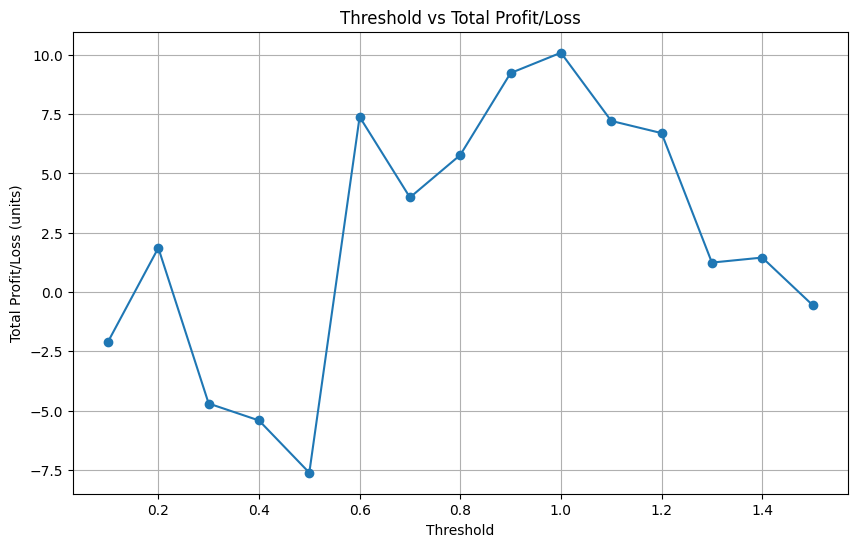


Summary of Threshold Optimization:
    threshold  total_profit_loss
0         0.1          -2.095918
1         0.2           1.861455
2         0.3          -4.696280
3         0.4          -5.411184
4         0.5          -7.613594
5         0.6           7.384254
6         0.7           3.987060
7         0.8           5.777263
8         0.9           9.229949
9         1.0          10.087011
10        1.1           7.213402
11        1.2           6.699130
12        1.3           1.242608
13        1.4           1.453856
14        1.5          -0.546144


In [88]:
# Define a range of thresholds to test (e.g., 0.1 to 1.5 in increments of 0.1)
threshold_values = [round(x * 0.1, 1) for x in range(1, 16)]  # [0.1, 0.2, ..., 1.5]

# Apply the find_optimal_threshold function
threshold_results = find_optimal_threshold(combined_shots_df, thresholds=threshold_values, plot=True)

# Display the summary of results
print("\nSummary of Threshold Optimization:")
print(threshold_results)

In [ ]:
get_player_sog_odds(player_name='Quinn Hughes', query_date='2024-12-01', sportsbook='fanduel', team_name='Vancouver Canucks')

In [76]:
combined_shots_df

,date,player,team,position,gp,toi,toi/gp,shots/60,icf/60,iff/60,min%,adj_min,x_shots,x_shots_mod,sog,handicap,over_odds,under_odds
0,2024-12-01,Brock Boeser,VAN,R,15,190.27,12.68,6.62,14.82,9.46,4.23,16.57,1.83,2.00,2.0,2.5,126.0,-165.0
1,2024-12-01,Conor Garland,VAN,R,22,310.42,14.11,6.96,14.11,11.21,4.70,18.41,2.14,2.34,6.0,2.5,-138.0,106.0
5,2024-12-01,Elias Pettersson,VAN,C,22,299.78,13.63,5.20,12.41,8.61,4.54,17.79,1.54,1.69,1.0,2.5,122.0,-160.0
6,2024-12-01,Kiefer Sherwood,VAN,L,22,256.92,11.68,8.87,17.05,13.31,3.89,15.24,2.25,2.46,1.0,1.5,-170.0,130.0
10,2024-12-01,Jake DeBrusk,VAN,L,22,284.90,12.95,6.95,13.27,9.69,4.32,16.93,1.96,2.15,1.0,2.5,122.0,-160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2274,2024-12-10,Jaden Schwartz,SEA,C,29,400.47,13.81,6.44,12.44,8.84,4.60,17.12,1.84,1.72,0.0,1.5,-140.0,108.0
2275,2024-12-10,Jared McCann,SEA,L,29,354.07,12.21,8.30,17.12,13.22,4.07,15.15,2.10,1.96,1.0,2.5,100.0,-130.0
2277,2024-12-10,Oliver Bjorkstrand,SEA,R,28,342.52,12.23,8.76,14.71,11.39,4.08,15.18,2.22,2.08,3.0,1.5,-188.0,142.0
2285,2024-12-10,Vince Dunn,SEA,D,9,152.78,16.98,5.50,12.17,6.68,5.66,21.06,1.93,1.80,4.0,1.5,-152.0,116.0


Root Mean Square Error (RMSE): 1.6638
Mean Absolute Error (MAE): 1.2773
R² Score: 0.0516


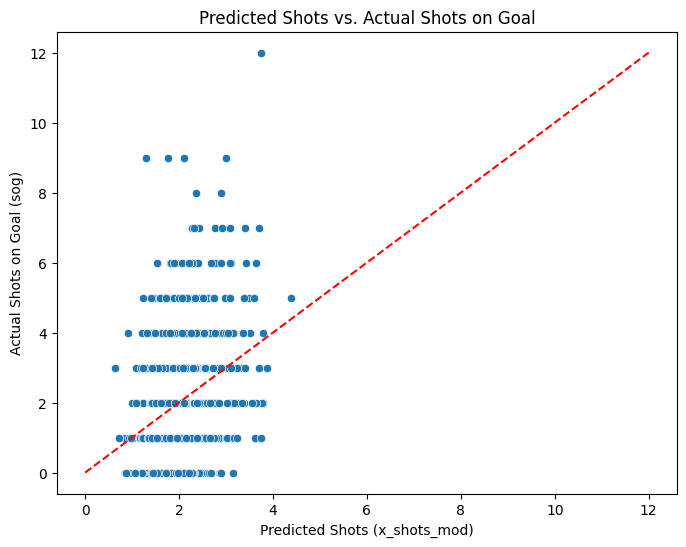

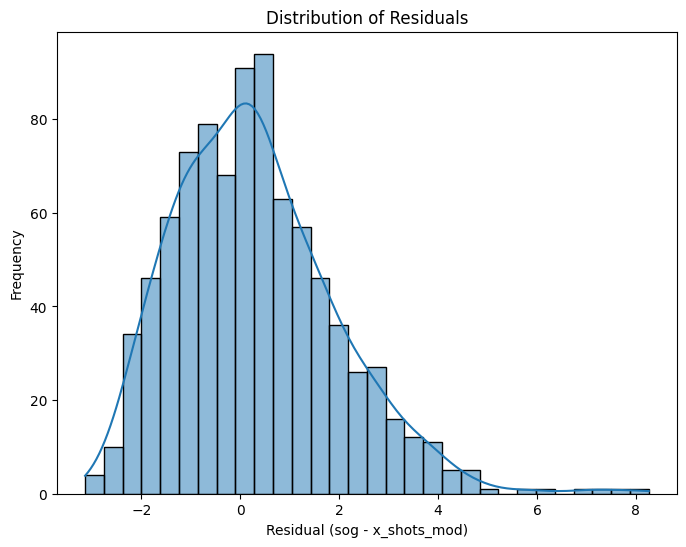

                 player      RMSE
0          Aaron Ekblad  2.875370
1         Adam Fantilli  1.168981
2              Adam Fox  2.164405
3          Adrian Kempe  1.045578
4     Aleksander Barkov  2.100042
..                  ...       ...
239    William Nylander  1.148033
240      Wyatt Johnston  0.493761
241  Yegor Sharangovich  1.183311
242          Zach Hyman  2.600481
243       Zach Werenski  1.868176

[244 rows x 2 columns]


/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_27370/3061046609.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  player_rmse = data.groupby('player').apply(


In [75]:
from db_utils.prop_odds_db_utils import american_to_decimal
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
data = combined_shots_df.dropna().copy()

# Ensure that the data is a deep copy to avoid SettingWithCopyWarning
data = combined_shots_df.dropna().copy()

# Convert American odds to Decimal odds using .loc
data.loc[:, 'over_decimal_odds'] = data['over_odds'].apply(american_to_decimal)
data.loc[:, 'under_decimal_odds'] = data['under_odds'].apply(american_to_decimal)

# If 'implied_over_prob' and 'implied_under_prob' are no longer needed, you can remove them
# data.loc[:, 'implied_over_prob'] = 1 / data['over_decimal_odds']
# data.loc[:, 'implied_under_prob'] = 1 / data['under_decimal_odds']

# Compare model predictions to actual shots on goal
# Calculate RMSE between model predictions and actual shots on goal
rmse = np.sqrt(mean_squared_error(data['sog'], data['x_shots_mod']))
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

# Calculate MAE for additional insight
mae = mean_absolute_error(data['sog'], data['x_shots_mod'])
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Calculate R² Score to understand variance explained by the model
r2 = r2_score(data['sog'], data['x_shots_mod'])
print(f"R² Score: {r2:.4f}")

# Optional: Visualize the relationship between predicted and actual shots
plt.figure(figsize=(8, 6))
sns.scatterplot(x='x_shots_mod', y='sog', data=data)
plt.plot([data['sog'].min(), data['sog'].max()], [data['sog'].min(), data['sog'].max()], 'r--')  # Diagonal line
plt.title('Predicted Shots vs. Actual Shots on Goal')
plt.xlabel('Predicted Shots (x_shots_mod)')
plt.ylabel('Actual Shots on Goal (sog)')
plt.show()

# Optional: Residual Analysis
data['residuals'] = data['sog'] - data['x_shots_mod']

plt.figure(figsize=(8, 6))
sns.histplot(data['residuals'], bins=30, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual (sog - x_shots_mod)')
plt.ylabel('Frequency')
plt.show()

# Optional: Per-Player RMSE
player_rmse = data.groupby('player').apply(
    lambda df: np.sqrt(mean_squared_error(df['sog'], df['x_shots_mod']))
).reset_index(name='RMSE')

print(player_rmse)